# Data cleaning: Air-BnB data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data_air/AB_NYC_2019.csv")

In [3]:
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


### Checking for missing values, and for duplicate entries

In [4]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
df.duplicated().sum()

0

No cleaning is done based on this.

### Boxplots to find outliers

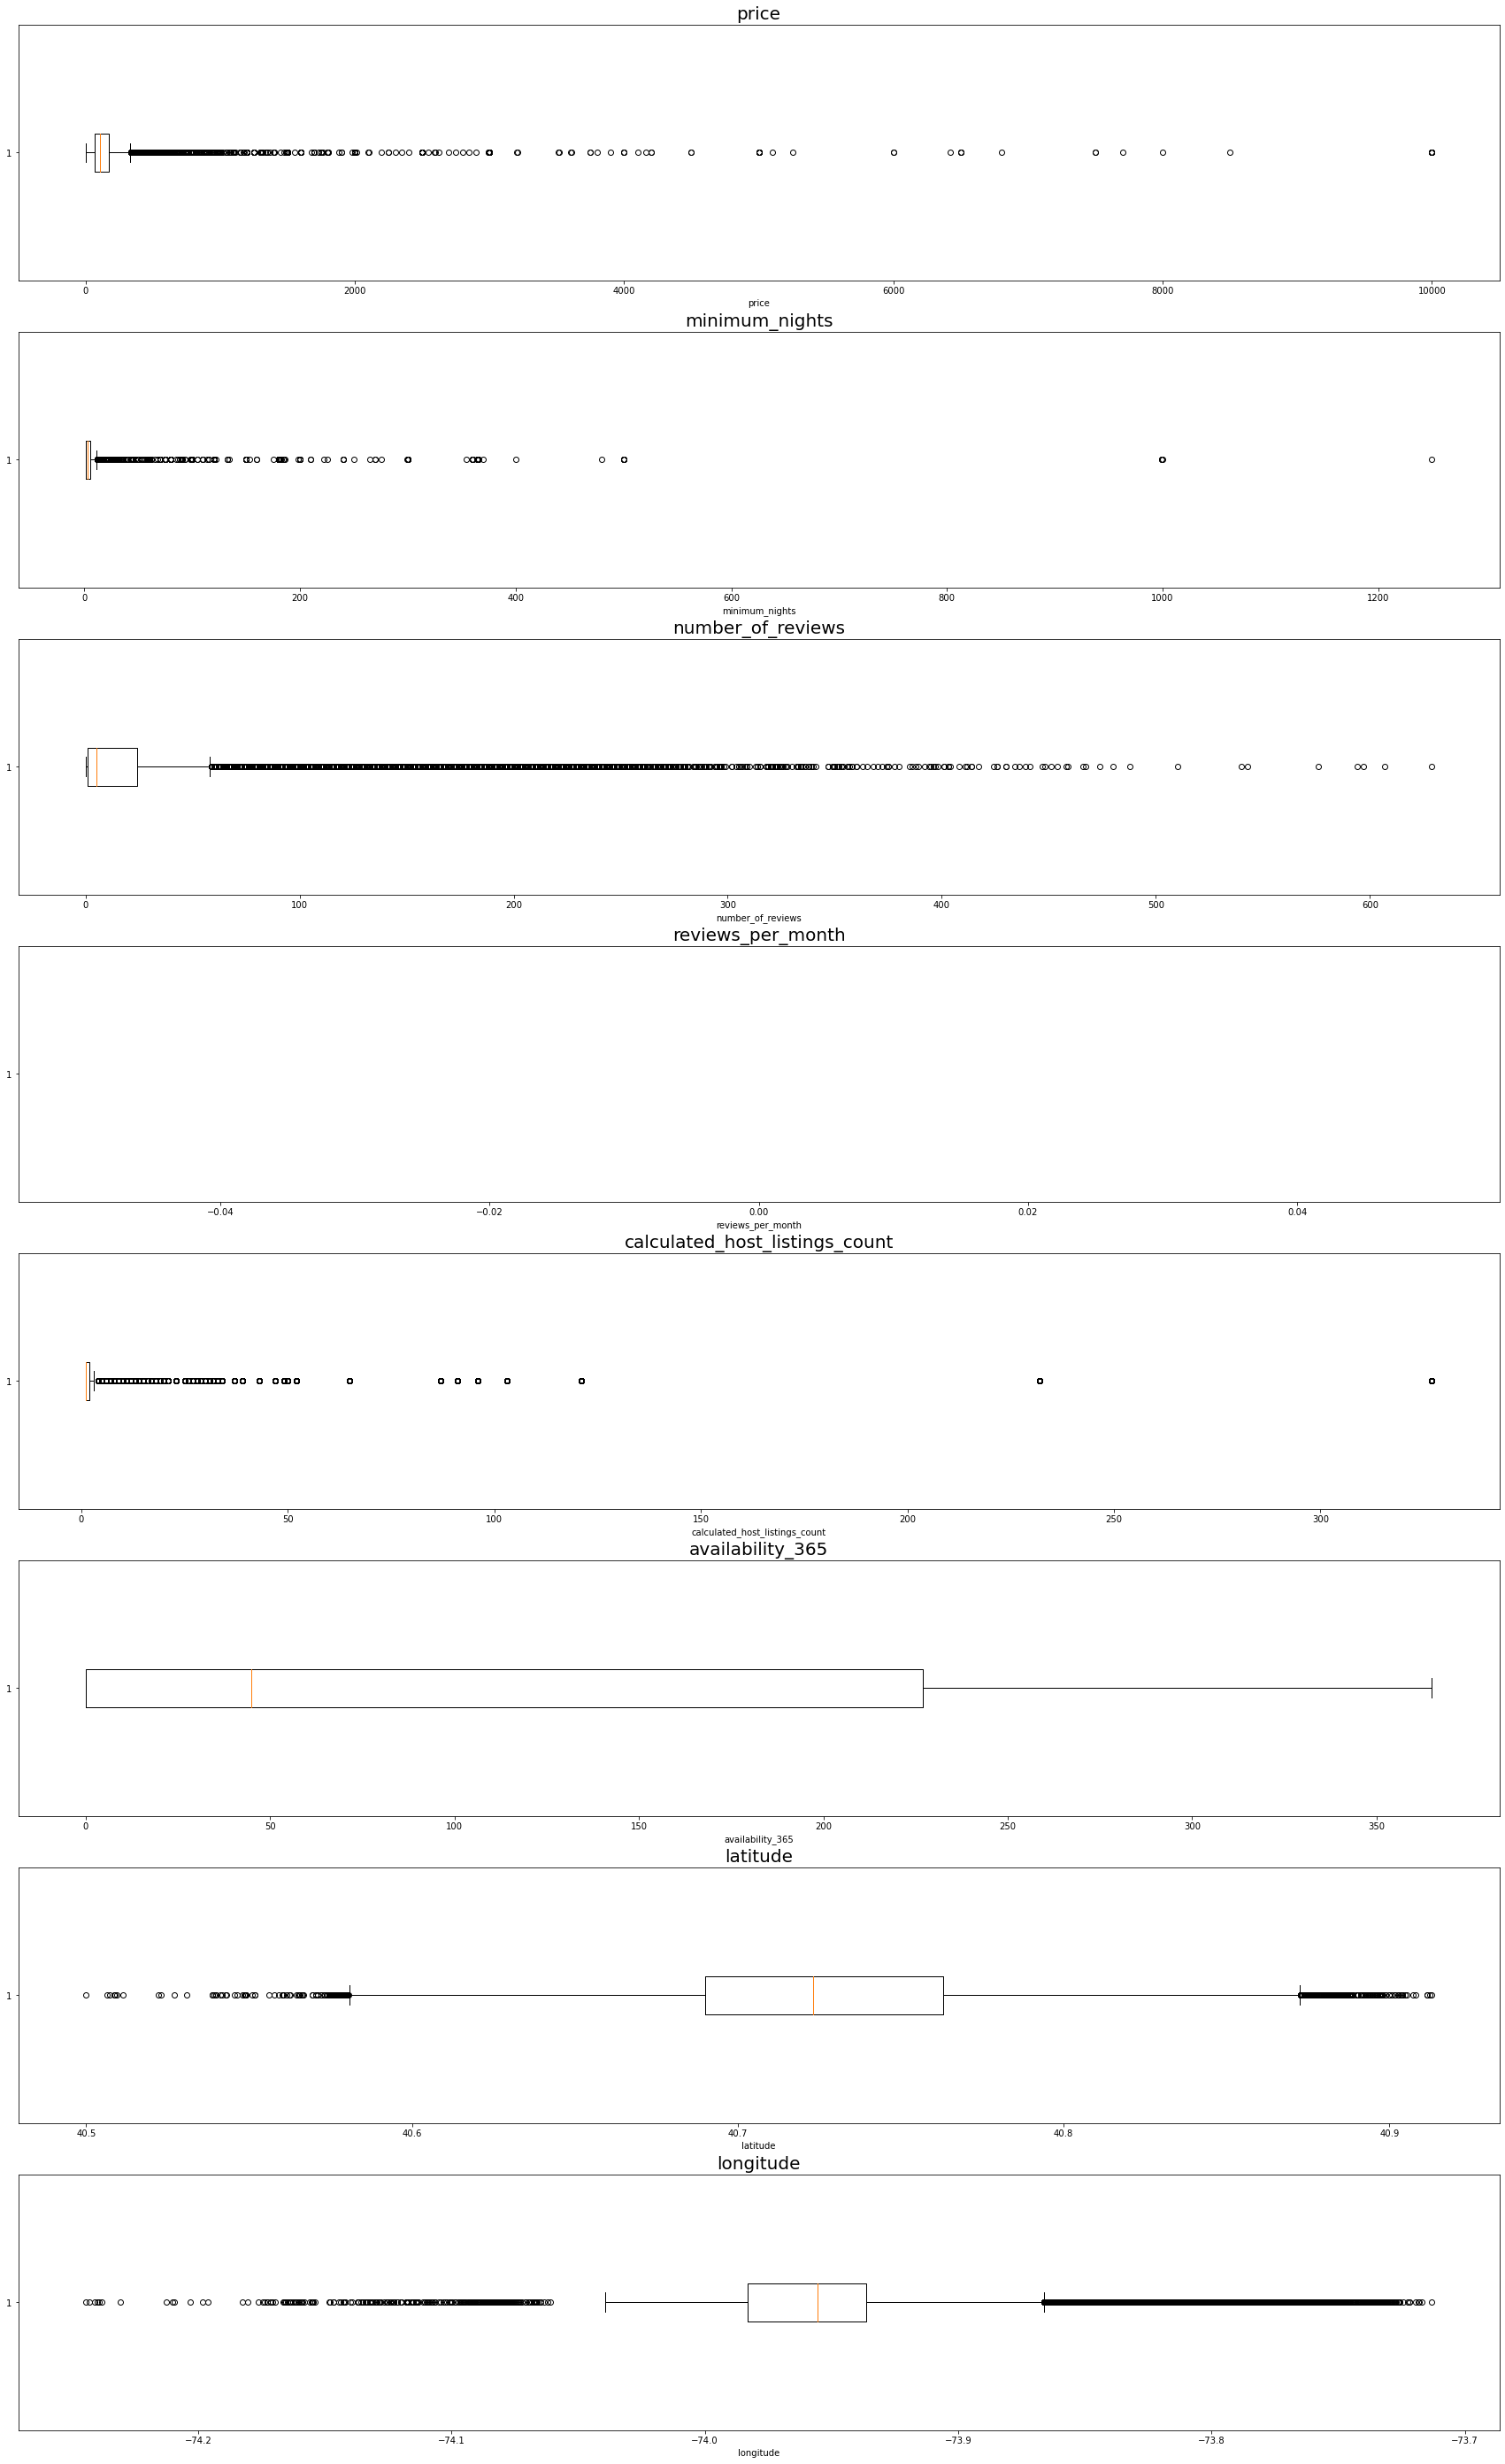

In [6]:
features = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude']


fig, axs = plt.subplots(len(features), 1, figsize=(30,50))
for i, feat in enumerate(features):
    data = df[feat].sort_values(ascending=False).reset_index(drop=True)
    axs[i].boxplot(data, vert = False)
    axs[i].set_xlabel(feat)
    axs[i].set_title(feat, fontsize=20)
plt.show()

From this we identified ``price``, ``minimum_nights`` and ``calculated_host_listings_count`` as variables we might want to reduce outliers in.

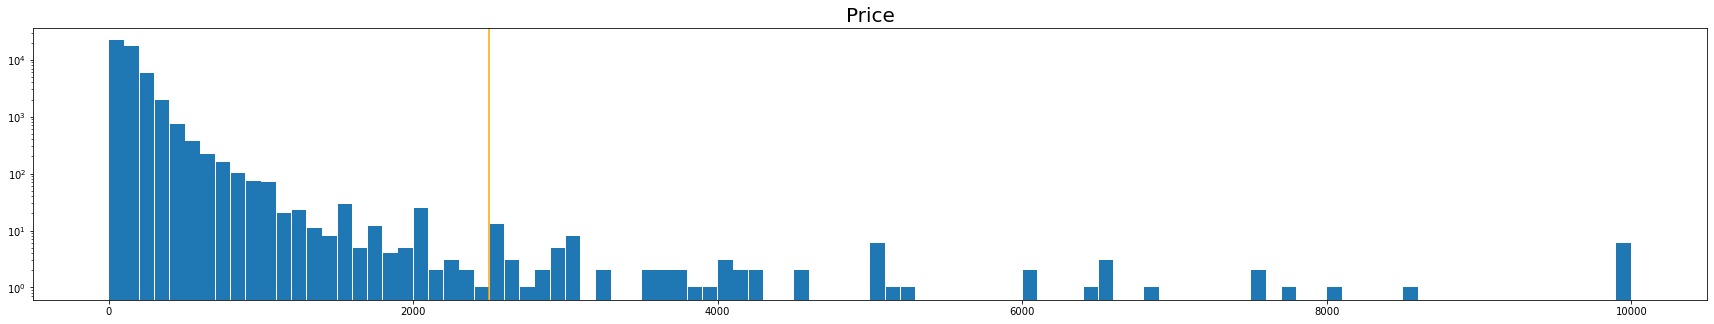

In [11]:
price_data = df.price.sort_values(ascending=False).reset_index(drop=True)
plt.figure(figsize=(30,5))
plt.hist(price_data, log=True, rwidth=0.95, bins=100)
plt.axvline(x=2500, color = 'orange')
plt.title('Price', fontsize=20)
plt.show()

From this we decided that removing all listings with a price above 2500\\$ could be deleted. Also we choose to remove listings with a price of 0\\$.

In [12]:
price_max = 2500
price_min = 0
bad_price_index = df.index[((price_min > df.price) | (df.price > price_max))]

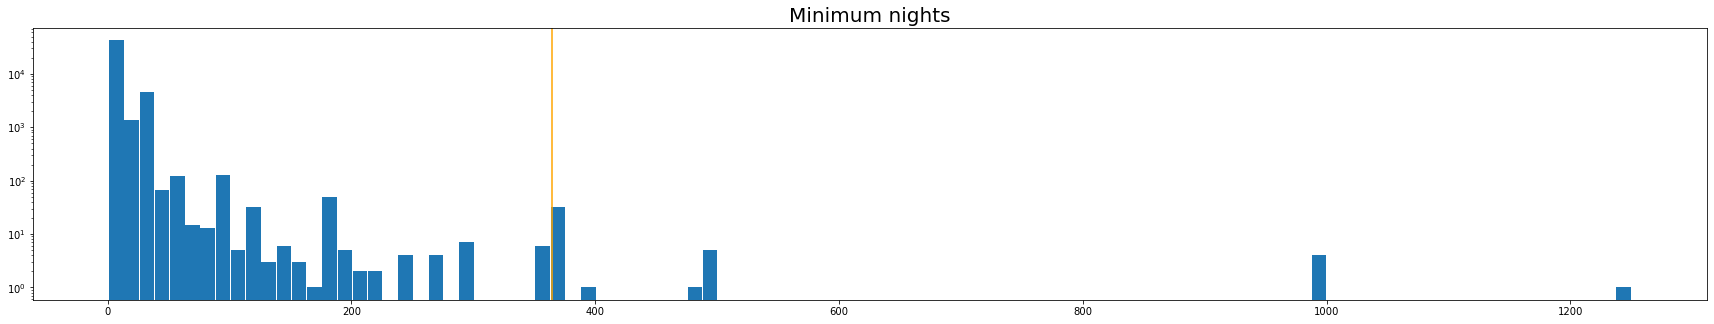

In [13]:
min_nights_data = df.minimum_nights.sort_values(ascending=False).reset_index(drop=True).dropna()
plt.figure(figsize=(30,5))
plt.hist(min_nights_data, log=True, rwidth=0.95, bins=100)
plt.axvline(x=365, color = 'orange')
plt.title('Minimum nights', fontsize=20)
plt.show()

From this we decided to remove all listings with that require the booking length to be more than one year.

In [14]:
nights_max = 365
nights_min = 0
bad_nights_index = df.index[((nights_min > df.minimum_nights) | (df.minimum_nights > nights_max))]

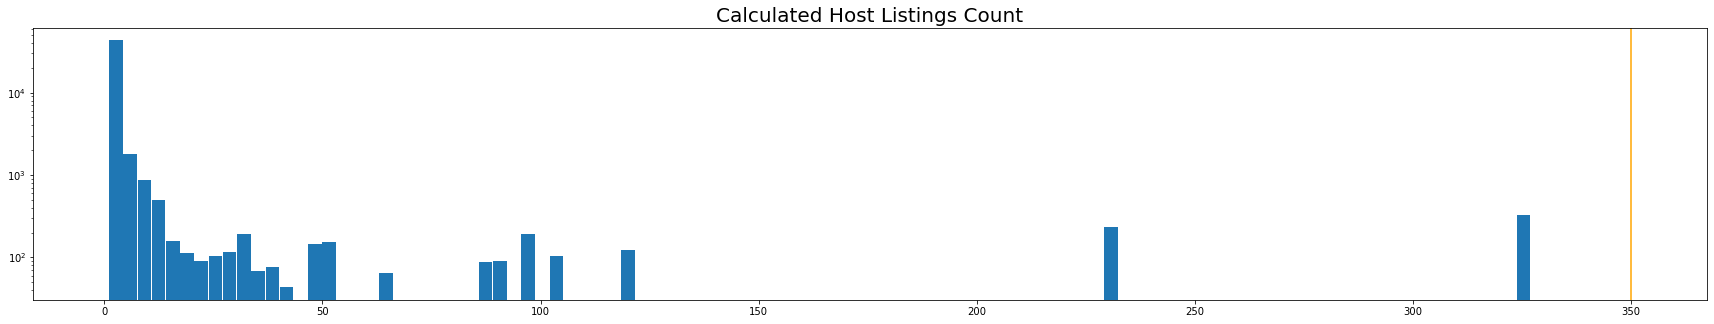

In [17]:
host_listings_data = df.calculated_host_listings_count.sort_values(ascending=False).reset_index(drop=True).dropna()
plt.figure(figsize=(30,5))
plt.hist(host_listings_data, log=True, rwidth=0.95, bins=100)
plt.axvline(x=350, color = 'orange')
plt.title('Calculated Host Listings Count', fontsize=20)
plt.show()

From this we decided not to remove any entries, since it seems probable that the two bins to the left are just *proffsional* Airbnb hosts, and it might be interesting to include in the data analysis.

In [12]:
count_max = 350
count_min = 0
bad_count_index = df.index[((count_min > df.calculated_host_listings_count) | (df.calculated_host_listings_count > count_max))]

In [13]:
bad_index = list(bad_price_index)+list(bad_nights_index)+list(bad_count_index)
print(len(set(bad_index)))
df = df.drop(bad_index)

91


Thus from this part of the data cleaning we only discarded 91 entries.

### Collecting rare categories in an 'other' category

In [14]:
print('Unique neighbourhood_group options:', *df.neighbourhood_group.unique())
print('Number of unique neighbourhood options', len(df.neighbourhood.unique()))


Unique neighbourhood_group options: Brooklyn Manhattan Queens Staten Island Bronx
Number of unique neighbourhood options 221


From this we decided we would probably need to encode the 'rare' neighbourhoods in to a new group called 'other' if we wanted to do plots on the neighbourhoods.

In [15]:
categories = ['neighbourhood']
other_cat_dic = {}
for cat in categories:
    print('----------------------------')
    other_cat_dic[cat] = {'tabel': df.groupby(cat).size().sort_values(ascending=False)}
    print(other_cat_dic[cat]['tabel'])

----------------------------
neighbourhood
Williamsburg          3916
Bedford-Stuyvesant    3706
Harlem                2654
Bushwick              2461
Upper West Side       1960
                      ... 
New Dorp                 1
Willowbrook              1
Fort Wadsworth           1
Richmondtown             1
Rossville                1
Length: 221, dtype: int64


From the output above we have choosen to threshold individual neighborhoods with less han 0.5% listings in them, to create an ``Other`` category in a new column 

In [16]:
other_thres = [round(df.shape[0]/200)] #any neighbourhood with less than 0.5% of the data are combined
for i, cat in enumerate(categories):
      other_cat_dic[cat]['threshold'] = other_thres[i]

func = lambda data: 'Other' if data in other_cats else data

for elem in other_cat_dic.values():
    other_cats = elem['tabel'][elem['tabel'].values < elem['threshold']].index
    cat = elem['tabel'].axes[0].name
    df[cat + '_other'] = list(map(func, df[cat]))


print('Number of unique neighbourhood options', len(df.neighbourhood_other.unique()))

Number of unique neighbourhood options 44


In [17]:
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_other
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,Other
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,Midtown


### Encoding of categorical data

Lastly we wanted to do encoding of the three categorical features, we expected to be relevant for the data analysis.<br>
We decided to do label encoding on the new ``neighbourhood_other`` column since 44 unique values still seemed too much to one-hot encode.

In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [19]:
columns_le_enc = ['neighbourhood_other',] #Labl encoding
columns_oh_enc = ['neighbourhood_group', 'room_type'] #One-hot encoding

le_enc = {}
for col in columns_le_enc:
    le_enc[col] = LabelEncoder()
    df[col + '_label'] = le_enc[col].fit_transform(df[col])

oh_enc = OneHotEncoder()
if len(columns_oh_enc) != 0:
    cols = df.loc[:,columns_oh_enc]
    cols_enc = oh_enc.fit_transform(cols).toarray()
    cols_enc_header = oh_enc.get_feature_names(columns_oh_enc)
    tmp = pd.DataFrame(data = cols_enc, columns = cols_enc_header)
    df = df.join(tmp, how='inner')

In [20]:
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,neighbourhood_other,neighbourhood_other_label,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,Other,29,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,Midtown,25,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [21]:
df.shape

(48713, 26)

<font color='darkred'>Note:</font> The cell below is disabled to avoid overwriting files

In [22]:
#df.to_csv(r'data_air\AB_data_clean.csv', index=False)